In [1]:
using Pkg
Pkg.activate("D:\\Science\\Code\\Julia\\envr")
using StaticArrays, DifferentialEquations, DynamicalSystems, JLD, LinearAlgebra
E_, x_, y_ = 0..30, 0..1, 0..1
box = IntervalBox(E_, x_, y_)
using CairoMakie
using GLMakie

  Activating project at `D:\Science\Code\Julia\envr`


In [2]:
function TM(u, p, t)
    U(y) = p[8] + p[9] / ( 1.0 + exp( -50.0 * (y - p[7]) ) )
    σ(x) = 1.0 / ( 1.0 + exp( -20.0 * (x-p[6]) ) )
    # u[1] - E; u[2] - x; u[3] - y
    # α - 1, τ - 2, τD - 3, τy - 4, J - 5, xthr - 6, ythr - 7, U0 - 8, ΔU0 - 9, β - 10, I0 -11
    du1 = (-u[1] + p[1] * log( 1.0 + exp( (p[5] * U(u[3]) * u[2] * u[1] + p[11]  ) / (p[1]) ) ) ) / p[2]
    du2 = (1.0 - u[2])/p[3] - U(u[3])*u[2]*u[1]
    du3 = (-u[3])/p[4] + p[10] * σ(u[2])
    return SA[du1, du2, du3]
end
function d(p1, p2)
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    dist = sqrt( (x1-x2)^2 + (y1-y2)^2 + (z1-z2)^2 )
    return dist
end

function labels3d(idx, idy, idz)
    if idx == 1
        x = "E"
    elseif idx == 2
        x = "x"
    else
        x = "y"
    end
    if idy == 1
        y = "E"
    elseif idy == 2
        y = "x"
    else
        y = "y"
    end
    if idz == 1
        z = "E"
    elseif idz == 2
        z = "x"
    else
        z = "y"
    end
    return x,y,z
end;

In [3]:
t = 9000.0; tstep = 0.001; Tt = 500.0
trange = range(0.0, t, step = tstep)
integ_set = (alg = RK4(), adaptive = false, dt = tstep)

const τ = 0.013;  const τD = 0.080;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4
const α = 1.58; const ΔU0 = 0.305;

In [4]:
path = "C:\\Users\\Home\\Desktop\\dynamical-systems\\Tsodyks Markram\\Levanova\\3 набор параметров\\2М Карта спектра Ляпуновских показателей\\200x200";
filenameLS = "\\LSs_200x200.jld"
filenameu0s = "\\u0s_200x200.jld"
pathLS = path*filenameLS
pathu0s = path*filenameu0s

Λs = load(pathLS)["data"]
u0s = load(pathu0s)["data"];

In [5]:
I0range = range( -1.40, -1.709, length = 201 )
U0range = range( 0.3,  0.47, length = 201);

In [19]:
idx_I0, idx_U0 = 128, 1
println("I0:",I0range[idx_I0], "; U0:",  U0range[idx_U0])
println(Λs[idx_I0, idx_U0, :])

I0_ = I0range[idx_I0]
U0_ = U0range[idx_U0]
p = SA[α, τ, τD, τy, J, xthr, ythr, U0_, ΔU0, β, I0_] #-1.7096211]

I0:-1.596215; U0:0.3
[0.0047134562221383845, -0.12801262717654965, -3.7517305222652158]


11-element SVector{11, Float64} with indices SOneTo(11):
  1.58
  0.013
  0.08
  3.3
  3.07
  0.75
  0.4
  0.3
  0.305
  0.3
 -1.596215

In [20]:
E, x, y = u0s[idx_I0, idx_U0, :]
u0 = SA[E, x, y]
ds = ContinuousDynamicalSystem(TM, u0, p)
tr = trajectory(ds, t, Δt = tstep; Ttr = 5000.0, diffeq = integ_set)
fp, eigs, stable = fixedpoints(ds, box);

In [21]:
distance = zeros(length(tr))

for i in range(1, length(distance), step = 1)
    distance[i] = d(tr[i], fp[1])
end
minimum(distance)

0.013080203407735016

In [22]:
vectors = LinearAlgebra.eigvecs(Array(jacobian(ds, fp[1], p, 0)))

3×3 Matrix{ComplexF64}:
  0.997034+0.0im     0.999872-0.0im            0.999872+0.0im
 -0.075811+0.0im   -0.0130827-0.00906433im   -0.0130827+0.00906433im
  0.013265+0.0im  0.000603668-0.00135026im  0.000603668+0.00135026im

In [23]:
eps = 1e-10
Efp, xfp, yfp = fp[1]
point = SA[Efp, xfp, yfp+eps]

3-element SVector{3, Float64} with indices SOneTo(3):
 8.58418999899321
 0.7348928849145953
 0.4207835249015538

In [24]:
ds1 = ContinuousDynamicalSystem(TM, point, p)
tr1 = trajectory(ds1, t, Δt = tstep; Ttr = 500.0, diffeq = integ_set);

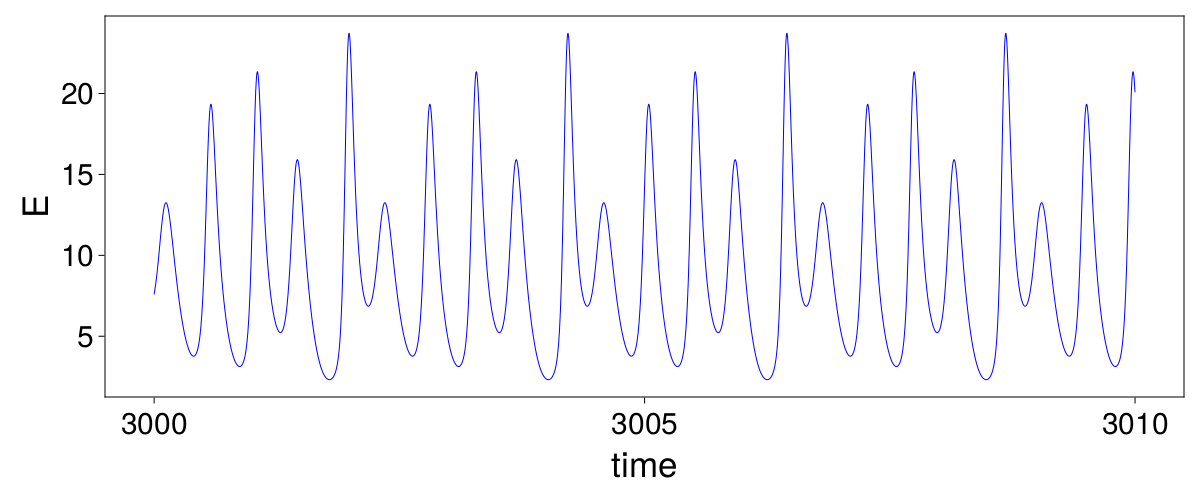

In [25]:
lb_size = 35; tck_size = 30;
ts, tf = 3000000, 3010000
CairoMakie.activate!()
f = Figure(resolution = (1200, 500))
axis = Axis(f[1, 1], xlabel = "time", ylabel = "E",
            xlabelsize = lb_size, ylabelsize = lb_size,
            xticklabelsize = tck_size, yticklabelsize = tck_size,
            xgridvisible = false, ygridvisible = false)
#lines!(axis, trange[ts:tf], tr[ts:tf, 1], linewidth = 1.0, color = :green)
lines!(axis, trange[ts:tf], tr1[ts:tf, 1], linewidth = 1.0, color = :blue)
f

In [26]:
ts, tf = 1, 9000000
idx, idy, idz = 2, 1, 3
xl, yl, zl = labels3d(idx,idy, idz)
GLMakie.activate!()
f = Figure(resolution = (900, 900))
ax = Axis3(f[1, 1], xlabel = xl, ylabel = yl, zlabel = zl,
            xlabelsize = 35, ylabelsize = 35, zlabelsize = 35,
            xgridvisible = false, ygridvisible = false, zgridvisible = false)

lines!(tr[ts:tf, idx], tr[ts:tf, idy], tr[ts:tf, idz], linewidth = 1.0, color = :green)
lines!(tr1[ts:tf, idx], tr1[ts:tf, idy], tr1[ts:tf, idz], linewidth = 0.5, color = :blue)

scatter!(fp[1][idx], fp[1][idy], fp[1][idz], markersize = 10, color = :red)
display(f)

GLMakie.Screen(...)

In [27]:
println(fp[1])
for eig in eigs[1]
    println(eig)
end

sf = fp[1];
saddle = 0
saddle_index = fp[1][2] / fp[1][1]
for eig in eigs[1]
    Re = real(eig)
    saddle+=Re
end
println()
println("Седловая величина:", saddle)
println("Седловой индекс:", saddle_index)

[8.58418999899321, 0.7348928849145953, 0.4207835248015538]
-8.68298373583699 + 0.0im
2.607001322990004 - 15.507770062678466im
2.607001322990004 + 15.507770062678466im

Седловая величина:-3.4689810898569817
Седловой индекс:0.08561004416267425
